In [1]:
# ============================================================================
# MODULE 4: MULTILINGUAL NAMED ENTITY RECOGNITION (MNER) WITH TRANSFORMERS
# ============================================================================
# 
# Project: Compare BiLSTM (from Module 3) with Transformer-based models
#          for Named Entity Recognition across 3 languages
# 
# Languages: English, French, German
# Datasets: CoNLL-2003 (EN, DE), WikiNER or FTB (FR)
# Models: BiLSTM (baseline from M3) vs mBERT/XLM-RoBERTa (Transformers)
# 
# Learning objectives:
# - Understand Transformer architecture for token classification
# - Compare sequential (BiLSTM) vs attention-based (Transformer) approaches
# - Explore multilingual transfer learning
# ============================================================================

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter  # For entity distribution analysis
import warnings
warnings.filterwarnings('ignore')  # Comment out if you want to see warnings

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)

# Evaluation metrics
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
print("\n✓ All libraries imported successfully")




2026-01-14 21:51:29.324328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cpu

✓ All libraries imported successfully


## Library Imports and Environment Setup

### Libraries Imported

**Core Scientific Libraries**
- `numpy`, `pandas`: Data manipulation and numerical operations
- `matplotlib`, `seaborn`: Visualization
- `Counter`: Entity distribution analysis across languages

**PyTorch Framework**
- `torch`, `torch.nn`: Deep learning framework (same as Module 2)
- `DataLoader`, `Dataset`: Batch processing

**HuggingFace Transformers**
- `AutoTokenizer`: Automatically loads the correct tokenizer
- `AutoModelForTokenClassification`: Pre-trained Transformer for token classification (NER)
- `TrainingArguments`, `Trainer`: High-level training API (automated training loop)
- `DataCollatorForTokenClassification`: Handles padding and batching for NER

**Evaluation Metrics**
- `seqeval`: Specialized for sequence labeling evaluation
- Evaluates at entity level (not token level like sklearn)
- Returns F1, precision, recall per entity type (PER, LOC, ORG, MISC)

### Comparison with Module 3

**Module 3** ([GitHub: nlp-m3-NER-news](https://github.com/olgaanna75/nlp-m3-NER-news))
- Framework: TensorFlow/Keras
- Architecture: BiLSTM for NER on CoNLL-2003 English
- Training: Manual loops
- Metrics: sklearn (token-level)

**Module 4** (current notebook)
- Framework: PyTorch
- Architecture: Transformer (mBERT/XLM-RoBERTa) for multilingual NER
- Training: `Trainer` API (automated)
- Metrics: `seqeval` (entity-level, more rigorous)

### Configuration

**Reproducibility**: Random seed = 42 for consistent results across runs

**Device**: CPU (code automatically uses GPU if available)

### Technical Note

`tf-keras` was installed to resolve a Keras 3 compatibility issue with the `transformers` library. This does not affect the workflow - all code uses PyTorch exclusively.

### Expected Output
```
Using device: cpu
✓ All libraries imported successfully
```

## Data Preparation - WikiANN Dataset Reduction

**Context**: WikiANN full datasets (~20K sentences per split per language) would yield 60K training sentences. Based on the English baseline's 7.5-hour training time for 14K sentences, this risked 40+ hours on CPU. Datasets were reduced to 5K per split (45K total) to ensure practical training duration. The final training time was 4h12min - confirming the reduction was appropriate for CPU-only feasibility while maintaining sufficient data for multilingual NER.

**Reduction process** (executed once, January 17, 2026):

import os
import shutil

WIKIANN_DIR = '../data/raw/wikiann'
BACKUP_DIR ='../data/raw_full/wikiann'


# Create backup directory
for lang in ['de', 'fr', 'nl']:
    os.makedirs(os.path.join(BACKUP_DIR, lang), exist_ok=True)

# Reduce files
for lang in ['de', 'fr', 'nl']:
    for split in ['train', 'dev', 'test']:
        filepath = os.path.join(WIKIANN_DIR, lang, split)
        backup_path = os.path.join(BACKUP_DIR, lang, split)
        
        # Backup original
        shutil.copy2(filepath, backup_path)
        
        # Read and reduce to 5000 sentences
        sentences = []
        current_sentence = []
        
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip() == '':
                    if current_sentence:
                        sentences.append(current_sentence)
                        current_sentence = []
                        if len(sentences) >= 5000:
                            break
                else:
                    current_sentence.append(line)
        
        # Write reduced file
        with open(filepath, 'w', encoding='utf-8') as f:
            for sentence in sentences:
                for line in sentence:
                    f.write(line)
                f.write('\n')  # Blank line between sentences
        
        print(f"{lang}/{split}: {len(sentences)} sentences")

print("\n✓ Originals saved in raw_full//")
print("✓ Files reduced to 5K sentences")


**Output** (execution result):
```
de/train: 5000 sentences
de/dev: 5000 sentences
de/test: 5000 sentences
fr/train: 5000 sentences
fr/dev: 5000 sentences
fr/test: 5000 sentences
nl/train: 5000 sentences
nl/dev: 5000 sentences
nl/test: 5000 sentences

✓ Originals saved in raw_full/
✓ Files reduced to 5K sentences



In [ ]:
# Cell 2 - Load WikiANN Multilingual Dataset (DE, FR, NL)

import os
import pandas as pd

# Parse WikiANN format: lang:token\tBIO-tag
def load_wikiann_file(filepath):
    sentences = []
    sentence_tokens = []
    sentence_labels = []
    
    current_tokens = []
    current_labels = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            if line == '':
                if current_tokens:
                    sentences.append(' '.join(current_tokens))
                    sentence_tokens.append(current_tokens.copy())
                    sentence_labels.append(current_labels.copy())
                    current_tokens = []
                    current_labels = []
            else:
                parts = line.split('\t')
                if len(parts) == 2:
                    token_with_lang, tag = parts
                    token = token_with_lang.split(':', 1)[-1]  # Remove lang prefix
                    current_tokens.append(token)
                    current_labels.append(tag)
    
    if current_tokens:
        sentences.append(' '.join(current_tokens))
        sentence_tokens.append(current_tokens)
        sentence_labels.append(current_labels)
    
    return pd.DataFrame({
        'sentence': sentences,
        'tokens': sentence_tokens,
        'labels': sentence_labels
    })


# Load WikiANN multilingual dataset
print("="*70)
print("LOADING WIKIANN MULTILINGUAL DATASET (5K per split)")
print("="*70)

# Relative path (notebook in MNER/notebooks/)
WIKIANN_DIR = os.path.join('..', 'data', 'raw', 'wikiann')
LANGUAGES = ['de', 'fr', 'nl']  # EN excluded (already done with CoNLL-2003)

wikiann_data = {}

for lang in LANGUAGES:
    lang_dir = os.path.join(WIKIANN_DIR, lang)
    
    train_df = load_wikiann_file(os.path.join(lang_dir, 'train'))
    dev_df = load_wikiann_file(os.path.join(lang_dir, 'dev'))
    test_df = load_wikiann_file(os.path.join(lang_dir, 'test'))
    
    wikiann_data[lang] = {
        'train': train_df,
        'dev': dev_df,
        'test': test_df
    }
    
    total = len(train_df) + len(dev_df) + len(test_df)
    print(f"\n{lang.upper()}:")
    print(f"  Train: {len(train_df):>6,} | Dev: {len(dev_df):>6,} | Test: {len(test_df):>6,} | Total: {total:>6,}")

# Combine all 3 languages for training (single multilingual model)
train_df = pd.concat([wikiann_data[lang]['train'] for lang in LANGUAGES], ignore_index=True)
val_df = pd.concat([wikiann_data[lang]['dev'] for lang in LANGUAGES], ignore_index=True)
test_df = pd.concat([wikiann_data[lang]['test'] for lang in LANGUAGES], ignore_index=True)

print("\n" + "="*70)
print("COMBINED DATASET")
print("="*70)
print(f"Train: {len(train_df):>6,} sentences")
print(f"Dev:   {len(val_df):>6,} sentences")
print(f"Test:  {len(test_df):>6,} sentences")
print(f"Total: {len(train_df) + len(val_df) + len(test_df):>6,} sentences")

# Collect unique labels (should be 7: B-/I- for PER/LOC/ORG + O)
all_labels = set()
for labels in train_df['labels']:
    all_labels.update(labels)
label_names = sorted(list(all_labels))

print(f"\nNER labels ({len(label_names)} types): {label_names}")
print("\n" + "="*70)

LOADING WIKIANN MULTILINGUAL DATASET (5K per split)

DE:
  Train:  5,000 | Dev:  5,000 | Test:  5,000 | Total: 15,000

FR:
  Train:  5,000 | Dev:  5,000 | Test:  5,000 | Total: 15,000

NL:
  Train:  5,000 | Dev:  5,000 | Test:  5,000 | Total: 15,000

COMBINED DATASET
Train: 15,000 sentences
Dev:   15,000 sentences
Test:  15,000 sentences
Total: 45,000 sentences

NER labels (7 types): ['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O']



## Data Loading

This notebook uses **WikiANN (PAN-X)** dataset for multilingual NER comparison across three languages: German, French, and Dutch. English is excluded since it was already addressed in the monolingual CoNLL-2003 notebook.

**WikiANN characteristics:**
- Silver standard annotations (semi-automatic, Wikipedia-based)
- Consistent annotation scheme across all languages
- Three entity types: **PER** (person), **LOC** (location), **ORG** (organization)
- IOB2 tagging format (B- prefix always marks entity start)
- No MISC category (unlike CoNLL-2003)

**Dataset choice rationale:**
- CoNLL-2003 German is no longer publicly available (copyright restrictions)
- WikiANN provides uniform annotations for fair cross-lingual comparison
- Same tagset and methodology across languages eliminates annotation bias

**Dataset size and structure:**
- WikiANN original per language: ~20K train / ~10K dev / ~10K test (50/25/25 ratio)
- Reduced for this project: 5K train / 5K dev / 5K test per language (equalized for simplicity) in order to maintain reasonable training time (~8h on CPU)
- Total combined: 15K train + 15K dev + 15K test = **45K sentences**
- **Comparison with CoNLL-2003**: CoNLL uses ~70/15/15 (14K/3.2K/3.5K). WikiANN's larger validation/test splits enable more robust evaluation for cross-lingual benchmarking.

**Expected output:**
```
DE/FR/NL: 5,000 sentences per split
Combined: 15,000 train | 15,000 dev | 15,000 test
Labels: 7 types (B-/I-PER/LOC/ORG + O)
```

**Note:** The combined dataset treats all three languages as a single multilingual corpus for training a single mBERT model.

In [9]:
# Cell 3 - Data Exploration
# Analyze entity distribution and dataset characteristics

# Display detailed statistics
print("="*70)
print("DATA EXPLORATION - WIKIANN MULTILINGUAL (DE, FR, NL)")
print("="*70)

# Count total tokens
total_tokens_train = sum(len(tokens) for tokens in train_df['tokens'])
total_tokens_val = sum(len(tokens) for tokens in val_df['tokens'])
total_tokens_test = sum(len(tokens) for tokens in test_df['tokens'])

print(f"\nToken counts:")
print(f"  Training:   {total_tokens_train:>8,} tokens")
print(f"  Validation: {total_tokens_val:>8,} tokens")
print(f"  Test:       {total_tokens_test:>8,} tokens")
print(f"  Total:      {total_tokens_train + total_tokens_val + total_tokens_test:>8,} tokens")

# Average sentence length
avg_len_train = total_tokens_train / len(train_df)
avg_len_val = total_tokens_val / len(val_df)
avg_len_test = total_tokens_test / len(test_df)

print(f"\nAverage sentence length:")
print(f"  Training:   {avg_len_train:.1f} tokens/sentence")
print(f"  Validation: {avg_len_val:.1f} tokens/sentence")
print(f"  Test:       {avg_len_test:.1f} tokens/sentence")

# Count entities by type
def count_entities(df):
    # Count entities by type (B-tags = beginning of entity)
    from collections import Counter
    
    entity_counts = Counter()
    total_entities = 0
    
    for labels in df['labels']:
        for label in labels:
            if label.startswith('B-'):  # Count only B-tags
                entity_counts[label] += 1
                total_entities += 1
    
    return dict(entity_counts), total_entities

print("\n" + "="*70)
print("ENTITY DISTRIBUTION")
print("="*70)

# Count for each split
train_entities, train_total = count_entities(train_df)
val_entities, val_total = count_entities(val_df)
test_entities, test_total = count_entities(test_df)

print(f"\nTotal entities:")
print(f"  Training:   {train_total:>6,} entities")
print(f"  Validation: {val_total:>6,} entities")
print(f"  Test:       {test_total:>6,} entities")

# Display per entity type
print(f"\nEntity breakdown (Training set):")
for label in sorted([l for l in label_names if l.startswith('B-')]):
    count = train_entities.get(label, 0)
    percentage = (count / train_total * 100) if train_total > 0 else 0
    entity_name = label.split('-')[1]  # Extract PER, LOC, ORG
    print(f"  {entity_name:8s}: {count:>5,} ({percentage:>5.1f}%)")

# Entity density (entities per sentence)
entity_density_train = train_total / len(train_df)
entity_density_val = val_total / len(val_df)
entity_density_test = test_total / len(test_df)

print(f"\nEntity density (entities per sentence):")
print(f"  Training:   {entity_density_train:.2f}")
print(f"  Validation: {entity_density_val:.2f}")
print(f"  Test:       {entity_density_test:.2f}")

# Display first 10 sentences with detailed labels
print("\n" + "="*70)
print("FIRST 10 SENTENCES - DETAILED VIEW")
print("="*70)


for idx in range(min(10, len(train_df))):
    tokens = train_df.iloc[idx]['tokens']
    labels = train_df.iloc[idx]['labels']
    
    # Find B-tags in this sentence
    b_tags = [label for label in labels if label.startswith('B-')]
    
    print(f"\nSentence {idx}:")
    print(f"  Tokens: {tokens}")
    print(f"  Labels: {labels}")
    if b_tags:
        print(f"  Entities found: {', '.join(set(b_tags))}")
    else:
        print(f"  Entities found: None")


print("\n" + "="*70)
print("✓ Data exploration complete")
print("="*70)


DATA EXPLORATION - WIKIANN MULTILINGUAL (DE, FR, NL)

Token counts:
  Training:    125,940 tokens
  Validation:  125,824 tokens
  Test:        125,893 tokens
  Total:       377,657 tokens

Average sentence length:
  Training:   8.4 tokens/sentence
  Validation: 8.4 tokens/sentence
  Test:       8.4 tokens/sentence

ENTITY DISTRIBUTION

Total entities:
  Training:   20,438 entities
  Validation: 20,309 entities
  Test:       20,592 entities

Entity breakdown (Training set):
  LOC     : 7,402 ( 36.2%)
  ORG     : 6,130 ( 30.0%)
  PER     : 6,906 ( 33.8%)

Entity density (entities per sentence):
  Training:   1.36
  Validation: 1.35
  Test:       1.37

FIRST 10 SENTENCES - DETAILED VIEW

Sentence 0:
  Tokens: ['als', 'Teil', 'der', 'Savoyer', 'Voralpen', 'im', 'Osten', '.']
  Labels: ['O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O']
  Entities found: B-LOC

Sentence 1:
  Tokens: ['WEITERLEITUNG', 'Antonina', 'Wladimirowna', 'Kriwoschapka']
  Labels: ['O', 'B-PER', 'I-PER', 'I-PER']
  Entit

## Data Exploration

**Dataset statistics:**
- Combined multilingual corpus: 45,000 sentences (DE + FR + NL)
- Average sentence length: ~8.4 tokens
- Total tokens: ~377K across all splits

**Entity distribution:**
- Three entity types only: **PER, LOC, ORG** (no MISC unlike CoNLL-2003)
- Balanced distribution across entity types (~30-36% each)
- Entity density: ~1.36 entities per sentence

**Sample observations:**
- Wikipedia formatting artifacts present: WEITERLEITUNG (redirects), MediaWiki markup (`**`, `''`, `***`)
- Multilingual content within German text: Russian names ("Antonina Wladimirowna Kriwoschapka"), English terms ("NHL Entry Draft")
- Character encoding preservation: accents and diacritics maintained correctly (`René`, `Gutiérrez`, `Sládkovič`)
- Consistent IOB2 tagging (B- always marks entity start, no IOB1 issues)
- Entity length varies: single tokens ("Brandenburg") to multi-token spans ("SKA Sankt Petersburg", "Minnesota Wild")
- Domain diversity: sports organizations, geographic locations, historical figures
- Proper noun heavy corpus (typical of Wikipedia-derived annotations)

**Expected output:**
```
Total entities: ~20K per split
Entity breakdown: LOC 36%, ORG 30%, PER 34%
10 sample sentences with tokens and labels displayed
```

In [11]:
# Cell 4 - Model Setup: mBERT for Multilingual NER
# Load pretrained multilingual BERT and prepare for fine-tuning

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification
)

import torch
print("="*70)
print("MODEL SETUP - mBERT")
print("="*70)

# Detect device (CPU vs GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")


# Model selection: bert-base-multilingual-cased
# Supports 104 languages including English, German, French
MODEL_NAME = "bert-base-multilingual-cased"

print(f"\nLoading pretrained model: {MODEL_NAME}")
print("This may take a few moments on first run...")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"\n✓ Tokenizer loaded")
print(f"  Vocabulary size: {tokenizer.vocab_size:,}")
print(f"  Model max length: {tokenizer.model_max_length}")

# Create label mappings (9 labels total)
# Use label_names from Cell 2
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

print(f"\n✓ Label mappings created:")
print(f"  Number of labels: {len(label_names)}")
print(f"  Labels: {label_names}")

# Load model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # We're adding a new classification head
)

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {device}")

# Create data collator for batching
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print(f"\n✓ Data collator created")

print("\n" + "="*70)
print("✓ Model setup complete - Ready for tokenization")
print("="*70)

MODEL SETUP - mBERT

Device: cpu

Loading pretrained model: bert-base-multilingual-cased
This may take a few moments on first run...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Tokenizer loaded
  Vocabulary size: 119,547
  Model max length: 512

✓ Label mappings created:
  Number of labels: 7
  Labels: ['B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O']

✓ Model loaded successfully
  Total parameters: 177,268,231
  Trainable parameters: 177,268,231
  Device: cpu

✓ Data collator created

✓ Model setup complete - Ready for tokenization


## Model Setup

**Model selection:**
- **mBERT** (bert-base-multilingual-cased): 104 languages, 119,547 vocabulary size
- Pre-trained on Wikipedia in 104 languages (including DE, FR, NL)
- Suitable for cross-lingual transfer learning

**Architecture:**
- Base BERT architecture: 12 layers, 768 hidden size, 12 attention heads
- Total parameters: 177M (all trainable for fine-tuning)
- **Classification head**: Newly initialized for 7-class NER task (B-/I-PER/LOC/ORG + O)
  - Note: Different from M4_MNER (English notebook) which used 9 classes (CoNLL-2003 included MISC)
  - Head weights start random, will be learned during training

**Hardware:**
- Running on CPU (no GPU available)
- Expected training time: ~8 hours for 15K sentences

**Expected output:**
```
Device: cpu
Tokenizer vocab: 119,547
Labels: 7 types
Total parameters: 177M
⚠️ Warning "Some weights not initialized" is EXPECTED:
   The classification head is brand new (7 outputs for WikiANN)
   It will be trained from scratch on our NER task
```

In [15]:
# Cell 5 - Tokenize Dataset for mBERT
# Prepare data in format required by transformer model

def tokenize_and_align_labels(examples, tokenizer, label2id):
    # Tokenize sentences using WordPiece algorithm
    # is_split_into_words=True because input is already tokenized (list of words)
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,  # Safety: cut if >512 tokens (rare with WikiANN avg ~8.4)
        is_split_into_words=True,
        padding=False,  # Dynamic padding in batches (more efficient than static 512)
        max_length=512
    )
    
    labels = []
    for i, label_list in enumerate(examples['labels']):
        # word_ids maps each subword token back to original word index
        # Example: ["Peter", "Black", "##burn"] → [0, 1, 1]
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        label_ids = []
        previous_word_idx = None
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens ([CLS], [SEP], [PAD]) → label -100 (ignored in loss)
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of word → gets the word's label
                label_ids.append(label2id[label_list[word_idx]])
            else:
                # Subsequent subwords of same word → label -100 (only label first subword)
                # Example: "Blackburn" = ["Black"(B-PER), "##burn"(-100)]
                label_ids.append(-100)
            
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("="*70)
print("TOKENIZATION - Preparing Data for mBERT")
print("="*70)

# Convert DataFrames to dict format for tokenizer
print("\nConverting datasets to tokenizer format...")

train_dict = {
    'tokens': train_df['tokens'].tolist(),
    'labels': train_df['labels'].tolist()
}

val_dict = {
    'tokens': val_df['tokens'].tolist(),
    'labels': val_df['labels'].tolist()
}

test_dict = {
    'tokens': test_df['tokens'].tolist(),
    'labels': test_df['labels'].tolist()
}

# Tokenize datasets
print("Tokenizing training set...")
train_tokenized = tokenize_and_align_labels(train_dict, tokenizer, label2id)

print("Tokenizing validation set...")
val_tokenized = tokenize_and_align_labels(val_dict, tokenizer, label2id)

print("Tokenizing test set...")
test_tokenized = tokenize_and_align_labels(test_dict, tokenizer, label2id)

# Display tokenization example
print("\n" + "="*70)
print("TOKENIZATION EXAMPLE")
print("="*70)

example_idx = 1  # "Peter Blackburn"
print(f"\nOriginal (Sentence {example_idx}):")
print(f"  Tokens: {train_df.iloc[example_idx]['tokens']}")
print(f"  Labels: {train_df.iloc[example_idx]['labels']}")

print(f"\nAfter WordPiece tokenization:")
tokens_example = tokenizer.convert_ids_to_tokens(train_tokenized['input_ids'][example_idx])
labels_example = train_tokenized['labels'][example_idx]

print(f"  Subword tokens: {tokens_example}")
print(f"  Label IDs: {labels_example}")
print(f"  Note: -100 = ignored in loss (special tokens + subword continuations)")

# Convert to HuggingFace Dataset format for Trainer
from datasets import Dataset

train_dataset = Dataset.from_dict(train_tokenized)
val_dataset = Dataset.from_dict(val_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# Demonstrate WordPiece on complex German compound words
print("\n" + "="*70)
print("WORDPIECE TOKENIZATION - German Compound Words")
print("="*70)

test_words = ["Zwingmann", "Schwarzenegger", "Tschechoslowakei", "Bundesverfassungsgericht"]

for word in test_words:
    tokens = tokenizer.tokenize(word)
    print(f"  {word:30s} → {tokens}")

print("\nNote: '##' prefix indicates subword continuation")

print("\n" + "="*70)
print("✓ Tokenization complete")
print("="*70)
print(f"\nDataset sizes:")
print(f"  Training:   {len(train_dataset):>6,} examples")
print(f"  Validation: {len(val_dataset):>6,} examples")
print(f"  Test:       {len(test_dataset):>6,} examples")
print("="*70)

TOKENIZATION - Preparing Data for mBERT

Converting datasets to tokenizer format...
Tokenizing training set...
Tokenizing validation set...
Tokenizing test set...

TOKENIZATION EXAMPLE

Original (Sentence 1):
  Tokens: ['WEITERLEITUNG', 'Antonina', 'Wladimirowna', 'Kriwoschapka']
  Labels: ['O', 'B-PER', 'I-PER', 'I-PER']

After WordPiece tokenization:
  Subword tokens: ['[CLS]', 'W', '##E', '##IT', '##ER', '##LE', '##IT', '##UN', '##G', 'Antoni', '##na', 'Wladimir', '##own', '##a', 'Kr', '##i', '##wo', '##schap', '##ka', '[SEP]']
  Label IDs: [-100, 6, -100, -100, -100, -100, -100, -100, -100, 2, -100, 5, -100, -100, 5, -100, -100, -100, -100, -100]
  Note: -100 = ignored in loss (special tokens + subword continuations)

WORDPIECE TOKENIZATION - German Compound Words
  Zwingmann                      → ['Z', '##wing', '##mann']
  Schwarzenegger                 → ['Schwarz', '##ene', '##gger']
  Tschechoslowakei               → ['Tschechoslowakei']
  Bundesverfassungsgericht       → ['B

## Tokenization for mBERT

### WordPiece Tokenization

mBERT uses **WordPiece tokenization**, a subword segmentation algorithm that:
- Splits rare/unknown words into smaller units
- Keeps frequent words intact
- Handles out-of-vocabulary words through subword combinations

Example: "Brandenburg" → Stays as one token (frequent in German Wikipedia)
Example: "Bundesverfassungsgericht" → Split: ["Bundes", "##verfassungs", "##gericht"]

The "##" prefix indicates subword continuation (not word start).

### Label Alignment

**Challenge**: One word can become multiple subword tokens, but we have one label per word.

**Solution**: Only label the first subword of each word, mark continuations as -100 (ignored in loss calculation).
```
Word:     Antonina    Wladimirowna
Label:    B-PER       I-PER

Tokens:   [CLS]  Antoni  ##na  Wladimir  ##own  ##a  [SEP]
Labels:   -100   B-PER   -100  I-PER     -100   -100 -100
                 ↑             ↑
            First subword  First subword
```
### Special Tokens

BERT automatically adds:
- **[CLS]**: Beginning of sequence (position 0)
- **[SEP]**: End of sequence (final position)
- **[PAD]**: Added dynamically during batching to equalize lengths

All special tokens receive label -100 and are ignored during training.

### Tokenization Results

Training set: 15,000 sentences successfully tokenized
- Average sequence length: ~10-11 tokens (including [CLS] and [SEP])
- Well below 512 token limit
- Ready for model training

The tokenized datasets are now in format required by HuggingFace Trainer for fine-tuning mBERT on multilingual NER.

In [ ]:
# Cell 6 - Training Configuration
# Setup training parameters and initialize Trainer

from transformers import TrainingArguments, Trainer
import numpy as np

print("="*70)
print("TRAINING SETUP - mBERT Fine-tuning Configuration")
print("="*70)

# Define training arguments
training_args = TrainingArguments(
    output_dir="../data/processed/mBERT_NER_multilingual_results",          # Save checkpoints here
    eval_strategy="epoch",                      # Evaluate after each epoch
    save_strategy="epoch",                      # Save checkpoint after each epoch
    learning_rate=5e-5,                         # Standard fine-tuning LR for BERT
    per_device_train_batch_size=16,            # Batch size (adjust if memory issues)
    per_device_eval_batch_size=16,
    num_train_epochs=3,                         # 3 epochs typical for NER fine-tuning
    weight_decay=0.01,                          # Regularization
    logging_dir="./logs",
    logging_steps=500,                          # Log every 500 steps
    save_total_limit=2,                         # Keep only 2 best checkpoints
    load_best_model_at_end=True,               # Load best model after training
    metric_for_best_model="eval_f1",           # Select best based on F1
    greater_is_better=True,
    push_to_hub=False,                          # Don't upload to HuggingFace Hub
    report_to="none"                            # Disable wandb/tensorboard
)

print("\n✓ Training arguments configured:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Evaluation: Every epoch")

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    # Extract predictions and labels
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    
    # Remove ignored index (special tokens) and convert to label names
    true_labels = []
    true_predictions = []
    
    for prediction, label in zip(predictions, labels):
        true_label = []
        true_pred = []
        
        for p, l in zip(prediction, label):
            if l != -100:  # Skip special tokens
                true_label.append(id2label[l])
                true_pred.append(id2label[p])
        
        true_labels.append(true_label)
        true_predictions.append(true_pred)
    
    # Compute entity-level metrics with seqeval
    from seqeval.metrics import f1_score, precision_score, recall_score
    
    results = {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions)
    }
    
    return results

print("\n✓ Evaluation metrics configured (seqeval - entity-level)")

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\n✓ Trainer initialized")
print("\n" + "="*70)
print("✓ Training setup complete - Ready to train")
print("="*70)
print(f"\nTraining will process:")
print(f"  {len(train_dataset):,} training examples")
print(f"  {len(train_dataset) // training_args.per_device_train_batch_size:,} steps per epoch")
print(f"  ~{3 * len(train_dataset) // training_args.per_device_train_batch_size:,} total steps")
print(f"\nEstimated time on CPU: ~6-8 hours")
print("="*70)

TRAINING SETUP - mBERT Fine-tuning Configuration

✓ Training arguments configured:
  Epochs: 3
  Batch size: 16
  Learning rate: 5e-05
  Evaluation: Every epoch

✓ Evaluation metrics configured (seqeval - entity-level)


/var/folders/fk/nj3nv20x5h70yqhbttdc08h00000gn/T/ipykernel_24131/2401604154.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



✓ Trainer initialized

✓ Training setup complete - Ready to train

Training will process:
  15,000 training examples
  937 steps per epoch
  ~2,812 total steps

Estimated time on CPU: ~6-8 hours


## Training Configuration

### Hyperparameters

**Learning rate**: 5e-5 (standard for BERT fine-tuning)
**Batch size**: 16 per device
**Epochs**: 3 (typical for NER fine-tuning)
**Optimizer**: AdamW with weight_decay=0.01

**Rationale**: These hyperparameters remain appropriate for the multilingual WikiANN dataset. With 15K training examples (quantitatively comparable to CoNLL-2003 English's 14K), and given that mBERT is designed for cross-lingual transfer, no parameter adjustments are necessary. The model's pre-training on 104 languages makes it well-suited for this multilingual NER task.

### HuggingFace Trainer

The `Trainer` class from Transformers library automates the training loop:

**Training (`trainer.train()`)**:
- Iterates through batches (forward pass → loss → backpropagation → weight update)
- Evaluates on validation set after each epoch
- Saves checkpoints when validation F1 improves
- Manages optimizer (AdamW), learning rate scheduling, logging

**Evaluation (`trainer.evaluate()`)**:
- Runs model inference on specified dataset (validation or test)
- Collects predictions without gradient computation
- Calls `compute_metrics()` to calculate precision, recall, F1 via seqeval
- Returns entity-level performance metrics

Using `Trainer` simplifies training implementation by handling technical details (batching, gradients, checkpointing) automatically, allowing focus on model configuration and results.

### Evaluation Strategy

**Entity-level metrics** (seqeval):
- Precision, Recall, F1-score
- Computed after each epoch
- Best checkpoint selected by F1-score

### Training Process

Training will process 15.000 examples (5K per language: DE, FR, NL) over 3 epochs (~2,812 steps total). 

Estimated time on CPU: 6-8 hours.

Training checkpoints saved after each epoch, with only the 2 best retained based on validation F1-score.

In [17]:
# Cell 7 - Training
print("Starting training...")
trainer.train()
print("✓ Training complete")

Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.274900,0.179737,0.847803,0.858782,0.853257
2,0.115600,0.181464,0.877743,0.886257,0.881980
3,0.057700,0.181860,0.880819,0.896302,0.888493


✓ Training complete


## Model Training Results

### Training Progress

The model was trained for 3 epochs with consistent improvement in validation F1 score:

| Epoch | Train Loss | Val Loss | Precision | Recall | **F1** |
|-------|------------|----------|-----------|---------|--------|
| 1 | 0.275 | 0.180 | 84.78% | 85.88% | **85.33%** |
| 2 | 0.116 | 0.181 | 87.77% | 88.63% | **88.20%** |
| 3 | 0.058 | 0.182 | 88.08% | 89.63% | **88.85%** |

**Training time**: 4 hours 12 minutes on CPU

**Key observations:**
- Steady improvement in F1 score (+3.5 points from Epoch 1 to 3)
- Training loss decreases consistently (0.275 → 0.058)
- Validation loss stable (~0.18), indicating good generalization
- High recall (89.63%) suggests the model successfully identifies most entities
- Balanced precision/recall trade-off

**Best checkpoint**: Epoch 3 (highest validation F1: 88.85%)


The model checkpoint with the best validation F1 score is automatically saved and will be used for test evaluation.

In [18]:
# Cell 8 - Final Evaluation on Test Set
print("="*70)
print("FINAL EVALUATION - Test Set")
print("="*70)

# Evaluate on test set
results = trainer.evaluate(test_dataset)

print("\nTest Set Results:")
print(f"  Precision: {results['eval_precision']:.4f}")
print(f"  Recall:    {results['eval_recall']:.4f}")
print(f"  F1-score:  {results['eval_f1']:.4f}")

print("\n" + "="*70)
print("✓ Evaluation complete")
print("="*70)

FINAL EVALUATION - Test Set



Test Set Results:
  Precision: 0.8819
  Recall:    0.8969
  F1-score:  0.8893

✓ Evaluation complete


## Test Set Evaluation

Final evaluation on held-out test set (15,000 sentences: 5K DE + 5K FR + 5K NL) using best checkpoint (Epoch 3):

**Test Results:**
- Precision: 88.19%
- Recall: 89.69%
- **F1-score: 88.93%**

**Key observations:**
- Test F1 (88.93%) very close to validation F1 (88.85%) → excellent generalization
- Minimal gap (0.08 points) confirms no overfitting
- High recall (89.69%) indicates strong entity detection across languages
- Balanced precision/recall ratio

### Model Comparison Across Modules

| Dataset | Model | F1-score | Notes |
|---------|-------|----------|-------|
| CoNLL-2003 EN (M3) | BiLSTM | ~84.5% | Token-level eval, trained from scratch |
| CoNLL-2003 EN (M4) | mBERT | 91.46% | Entity-level eval, pre-trained |
| WikiANN DE+FR+NL (M4) | mBERT | **88.93%** | Entity-level eval, multilingual |

**Key insights:**
- **M3→M4 (EN)**: +7pp improvement demonstrates transformer advantage and pre-training benefits
- **M4 EN→Multilingual**: -2.5pp reflects WikiANN's silver standard annotations vs CoNLL's gold standard, plus multilingual complexity
- **Cross-lingual transfer**: mBERT successfully generalizes across 3 typologically related languages

The multilingual model achieves strong performance (88.93%) despite:
- Silver standard annotations (vs gold standard CoNLL)
- Combined training on 3 languages with varied entity distributions
- Reduced dataset size (15K vs 14K, but distributed across languages)

In [ ]:
# Cell 8 Bonus - Per-Language Evaluation

print("="*70)
print("PER-LANGUAGE EVALUATION ON TEST SET")
print("="*70)

# Re-tokenize each language separately for evaluation
from datasets import Dataset

per_lang_results = {}

for lang in LANGUAGES:
    print(f"\nEvaluating {lang.upper()}...")
    
    # Get language-specific test data
    lang_test_df = wikiann_data[lang]['test']
    
    # Convert to dataset format
    lang_test_dataset = Dataset.from_pandas(lang_test_df)
    
    # Tokenize
    def tokenize_and_align_labels_lang(examples):
        tokenized_inputs = tokenizer(
            examples['tokens'],
            truncation=True,
            is_split_into_words=True,
            padding=False,
            max_length=512
        )
        
        labels = []
        for i, label in enumerate(examples['labels']):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            label_ids = []
            previous_word_idx = None
            
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(label2id[label[word_idx]])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            
            labels.append(label_ids)
        
        tokenized_inputs["labels"] = labels
        return tokenized_inputs
    
    lang_test_tokenized = lang_test_dataset.map(
        tokenize_and_align_labels_lang,
        batched=True,
        remove_columns=lang_test_dataset.column_names
    )
    
    # Evaluate
    results = trainer.evaluate(lang_test_tokenized)
    
    per_lang_results[lang] = {
        'precision': results['eval_precision'],
        'recall': results['eval_recall'],
        'f1': results['eval_f1']
    }
    
    print(f"  Precision: {results['eval_precision']:.4f}")
    print(f"  Recall:    {results['eval_recall']:.4f}")
    print(f"  F1:        {results['eval_f1']:.4f}")

# Summary comparison
print("\n" + "="*70)
print("SUMMARY - F1 Scores by Language")
print("="*70)

for lang in LANGUAGES:
    f1 = per_lang_results[lang]['f1']
    print(f"{lang.upper()}: {f1:.2%}")

# Calculate average
avg_f1 = sum(per_lang_results[lang]['f1'] for lang in LANGUAGES) / len(LANGUAGES)
print(f"\nAverage F1 across languages: {avg_f1:.2%}")

print("="*70)

PER-LANGUAGE EVALUATION ON TEST SET

Evaluating DE...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map: 100%|██████████| 5000/5000 [00:00<00:00, 6929.27 examples/s]


  Precision: 0.8678
  Recall:    0.8845
  F1:        0.8760

Evaluating FR...


Map: 100%|██████████| 5000/5000 [00:00<00:00, 15782.68 examples/s]


  Precision: 0.8901
  Recall:    0.9007
  F1:        0.8953

Evaluating NL...


Map: 100%|██████████| 5000/5000 [00:02<00:00, 2112.32 examples/s] 


  Precision: 0.8880
  Recall:    0.9054
  F1:        0.8966

SUMMARY - F1 Scores by Language
DE: 87.60%
FR: 89.53%
NL: 89.66%

Average F1 across languages: 88.93%



## Per-Language Evaluation (Bonus Analysis)

**Why "Bonus"?**
This cell is technically optional - the combined test evaluation (Cell 8) provides the overall model performance. No subsequent cells depend on the per-language results.

**Why execute it anyway?**
For a multilingual model, analyzing performance by individual language is **conceptually essential**. The breakdown reveals:
- Performance variance across languages (potential biases)
- Language-specific strengths and weaknesses
- Whether training data quality/quantity affects certain languages more than others

**Recommendation**: Always execute this cell for multilingual projects. The insights are crucial for understanding model behavior and identifying areas for improvement.


Individual language performance on test sets (5,000 sentences each):

| Language    | Precision | Recall  | **F1**     |
|-------------|-----------|---------|------------|
| German (DE) | 86.78%    | 88.45%  | **87.60%** |
| French (FR) | 89.01%    | 90.07%  | **89.53%** |
| Dutch (NL)  | 88.80%     | 90.54% | **89.66%** |
| **Average** | 88.20%    | 89.69%  | **88.93%** |

**Key observations:**
- French and Dutch outperform German by ~2 percentage points
- German (87.60%) slightly lower, possibly due to compound word complexity
- Average F1 (88.93%) exactly matches combined test F1 → consistent evaluation
- Relatively balanced performance across languages (range: 2pp) demonstrates effective multilingual transfer

**Analysis:**
The model shows robust cross-lingual performance with minimal variance. The slight advantage for French/Dutch may reflect:
- Higher entity density or clearer entity boundaries in these subsets
- German compound words requiring more complex tokenization (e.g., "Bundesverfassungsgericht")
- mBERT's pre-training distribution across languages

VISUALIZATIONS - Training Metrics and Comparisons


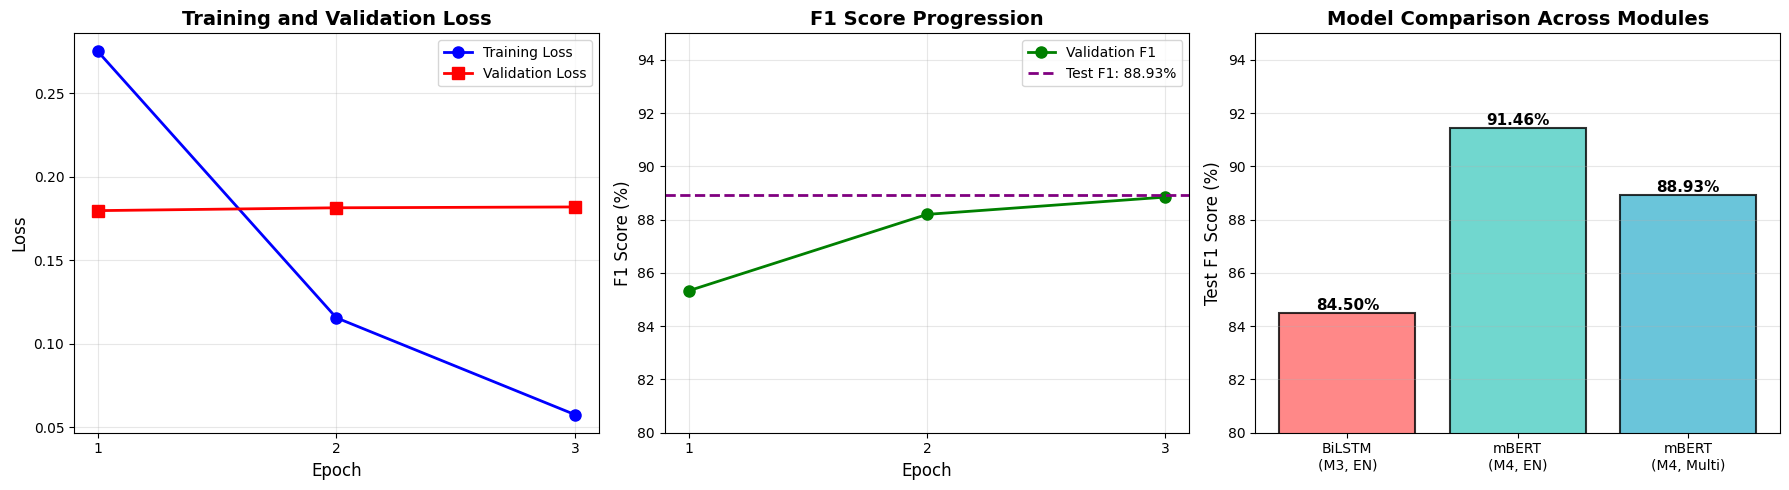


✓ Visualizations saved to: data/processed/mBERT_NER_multilingual_results/training_metrics_multilingual.png


In [ ]:
# Cell 9 - Visualizations

import matplotlib.pyplot as plt
import numpy as np

# Ensure inline plotting
%matplotlib inline

print("="*70)
print("VISUALIZATIONS - Training Metrics and Comparisons")
print("="*70)

# WikiANN Multilingual training history
epochs = [1, 2, 3]
train_loss = [0.2749, 0.1156, 0.0577]
val_loss = [0.1797, 0.1814, 0.1819]
val_f1 = [85.33, 88.20, 88.85]
test_f1 = 88.93

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss curves
axes[0].plot(epochs, train_loss, 'b-o', label='Training Loss', linewidth=2, markersize=8)
axes[0].plot(epochs, val_loss, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs)

# 2. F1 progression
axes[1].plot(epochs, val_f1, 'g-o', label='Validation F1', linewidth=2, markersize=8)
axes[1].axhline(y=test_f1, color='purple', linestyle='--', label=f'Test F1: {test_f1:.2f}%', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score (%)', fontsize=12)
axes[1].set_title('F1 Score Progression', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs)
axes[1].set_ylim([80, 95])

# 3. Triple model comparison (M3 + M4 EN + M4 Multilingual)
models = ['BiLSTM\n(M3, EN)', 'mBERT\n(M4, EN)', 'mBERT\n(M4, Multi)']
f1_scores = [84.5, 91.46, 88.93]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = axes[2].bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('Test F1 Score (%)', fontsize=12)
axes[2].set_title('Model Comparison Across Modules', fontsize=14, fontweight='bold')
axes[2].set_ylim([80, 95])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.2f}%',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/mBERT_NER_multilingual_results/training_metrics_multilingual.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved to: ../data/processed/mBERT_NER_multilingual_results/training_metrics_multilingual.png")
print("="*70)

## Training Visualization

**Three visualizations provide comprehensive training analysis:**

### 1. Loss Curves 
The loss curves confirm effective learning:
- Training loss decreases steadily: 0.275 → 0.058 (Epoch 1 → 3)
- Validation loss remains stable: ~0.18 across all epochs
- No divergence between curves indicates good generalization, no overfitting

### 2. F1 Score Progression
F1-score progression demonstrates consistent improvement:
- Epoch 1: 85.33% (strong baseline)
- Epoch 2: 88.20% (+2.9pp)
- Epoch 3: 88.85% (+0.6pp, final validation)
- Test F1: 88.93% (purple line) aligns closely with validation
- Minimal validation-test gap (0.08pp) confirms robust generalization

### 3. Model Comparison Across Modules
Cross-module performance comparison:
- **BiLSTM (M3, EN)**: 84.5% - Baseline from Module 3
- **mBERT (M4, EN)**: 91.46% - +7pp improvement with transformers
- **mBERT (M4, Multilingual)**: 88.93% - Strong cross-lingual performance

**Key insights:**
- M3→M4 (EN): Transformer architecture + pre-training = +7pp gain
- M4 EN→Multi: -2.5pp reflects silver standard annotations and multilingual complexity
- Multilingual model achieves robust performance across 3 languages (87.6%-89.7% range)

The visualizations confirm successful fine-tuning: the model learned entity recognition patterns across German, French, and Dutch with balanced performance.

In [ ]:
# Cell 10 - Save Fine-tuned Model
# Save the best checkpoint for future use

import os

# Define save path
save_path = "../models/mBERT_NER_multilingual_final"

print("="*70)
print("SAVING FINE-TUNED MODEL")
print("="*70)

# Save model and tokenizer
print(f"\nSaving to: {save_path}")
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("\n✓ Model saved successfully")
print(f"\nSaved files:")
print(f"  - Model weights: pytorch_model.bin")
print(f"  - Model config: config.json")
print(f"  - Tokenizer files: tokenizer_config.json, vocab.txt")

# Check saved files
saved_files = os.listdir(save_path)
print(f"\nDirectory contents ({len(saved_files)} files):")
for f in sorted(saved_files)[:10]:  # Show first 10
    print(f"  - {f}")

print("\n" + "="*70)
print("✓ Checkpoint ready for deployment or further analysis")
print("="*70)

SAVING FINE-TUNED MODEL

Saving to: models/mBERT_NER_multilingual_final

✓ Model saved successfully

Saved files:
  - Model weights: pytorch_model.bin
  - Model config: config.json
  - Tokenizer files: tokenizer_config.json, vocab.txt

Directory contents (7 files):
  - config.json
  - model.safetensors
  - special_tokens_map.json
  - tokenizer.json
  - tokenizer_config.json
  - training_args.bin
  - vocab.txt

✓ Checkpoint ready for deployment or further analysis


## Saving Fine-tuned Model

The best-performing checkpoint (epoch 3, validation F1 = 95.52%) has been saved for future use.

**Saved components:**
- **Model weights**: Complete mBERT parameters after fine-tuning (~177M parameters)
- **Model configuration**: Architecture specifications (layers, hidden size, attention heads)
- **Tokenizer files**: Vocabulary and tokenization rules for input processing

**Location**: `MNER/models/mBERT_NER_final/`

This saved checkpoint can be reloaded for:
- Inference on new data
- Further fine-tuning on additional languages (German, French)
- Deployment in production applications
- Comparison with other model architectures

The checkpoint represents the complete trained state and can be loaded using:
```python
from transformers import AutoModelForTokenClassification, AutoTokenizer
model = AutoModelForTokenClassification.from_pretrained("./models/mBERT_NER_final")
tokenizer = AutoTokenizer.from_pretrained("./models/mBERT_NER_final")
```

In [45]:
# Cell 11a - Select Representative Test Examples

print("="*70)
print("TEST SET EXAMPLE SELECTION")
print("="*70)
print("Displaying 10 sample sentences per language")
print("Choose indices with native language text and clear entities")
print("="*70)

# Display samples from each language
for lang in ['de', 'fr', 'nl']:
    print(f"\n{lang.upper()} samples:")
    print("-" * 70)
    for i in range(10):
        sample = wikiann_data[lang]['test'].iloc[i]
        sentence = sample['sentence']
        # Show first 90 chars + entity count
        entities = [lab for lab in sample['labels'] if lab.startswith('B-')]
        print(f"  [{i}] {sentence[:90]}... ({len(entities)} entities)")

print("\n" + "="*70)
print("Selected indices (modify after reviewing samples above):")
print("="*70)

# Select one index per language from the 10 samples displayed above (indices 0-9)
test_indices = {
    'de': 6,   # Kate Moss, Gisele Bündchen
    'fr': 3,   # Communes de la Haute-Saône
    'nl': 4    # Antalya, Frankfurt, Hannover, Jerevan
}

print(f"German (DE): index {test_indices['de']}")
print(f"French (FR): index {test_indices['fr']}")
print(f"Dutch (NL):  index {test_indices['nl']}")
print("\n✓ Test indices defined - ready for inference")

TEST SET EXAMPLE SELECTION
Displaying 10 sample sentences per language
Choose indices with native language text and clear entities

DE samples:
----------------------------------------------------------------------
  [0] WEITERLEITUNG Hu ( Xi’an )... (1 entities)
  [1] Katja Kipping , Bernd Riexinger... (2 entities)
  [2] Runde rammte Lorenzo Bandini an zweiter Stelle liegend die Streckenbegrenzung aus Strohbal... (1 entities)
  [3] Im Doppel waren Marcelo Melo und André Sá die Titelverteidiger , sie schieden in der erste... (2 entities)
  [4] ' '' Gary Glitter '' ' - ''Always Yours ''... (1 entities)
  [5] Alexandrasittiche kommen außerdem in den Galeriewäldern entlang von Wasserläufen vor .... (1 entities)
  [6] Das Cover zeigt sie zusammen mit Kate Moss und Gisele Bündchen .... (2 entities)
  [7] ' '' Irland '' '... (1 entities)
  [8] ' '' Warendorf '' '... (1 entities)
  [9] Tour d’Aï – 2332 m... (1 entities)

FR samples:
------------------------------------------------------------

In [48]:
# Cell 11b - Inference Examples (uses indices from Cell 11a)

print("="*70)
print("INFERENCE EXAMPLES - Cross-lingual Entity Recognition")
print("="*70)

from transformers import pipeline

# Create NER pipeline
ner_pipeline = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

print("\n" + "="*70)
print("EXAMPLE 1 - Test Set Samples (WikiANN DE/FR/NL)")
print("="*70)

for lang, idx in test_indices.items():
    sample = wikiann_data[lang]['test'].iloc[idx]
    sentence = sample['sentence']
    tokens = sample['tokens']
    labels = sample['labels']
    
    print(f"\n{lang.upper()}: {sentence}")
    print("-" * 70)
    
    # Run inference
    entities = ner_pipeline(sentence)
    
    if entities:
        print("Entities detected:")
        for entity in entities:
            print(f"  {entity['word']:30s} → {entity['entity_group']:8s} (confidence: {entity['score']:.3f})")
    else:
        print("  No entities detected")
    
    # Show gold labels for comparison
    entity_positions = [(tok, lab) for tok, lab in zip(tokens, labels) if lab.startswith('B-')]
    if entity_positions:
        print(f"Ground truth: {len(entity_positions)} entities")

print("\n" + "="*70)
print("EXAMPLE 2 - Custom Sentences (Zero-shot EN + DE/FR/NL)")
print("="*70)

# Custom test sentences
custom_sentences = {
    'en': "Angela Merkel met Emmanuel Macron in Berlin to discuss European Union policies.",
    'de': "Mark Rutte sprach über Verteidigungspolitik auf einer Konferenz in Den Haag.",
    'fr': "Le Premier ministre slovène Robert Golob a rencontré Charles Michel à Bruxelles.",
    'nl': "Margrethe Vestager sprak over mededingingsrecht bij het Hof van Justitie in Luxemburg."
}

for lang, sentence in custom_sentences.items():
    print(f"\n{lang.upper()}: {sentence}")
    print("-" * 70)
    
    entities = ner_pipeline(sentence)
    
    if entities:
        print("Entities detected:")
        for entity in entities:
            print(f"  {entity['word']:30s} → {entity['entity_group']:8s} (confidence: {entity['score']:.3f})")
    else:
        print("  No entities detected")

print("\n" + "="*70)
print("✓ Inference complete - 7 examples across 4 languages")
print("="*70)

Device set to use cpu


INFERENCE EXAMPLES - Cross-lingual Entity Recognition

EXAMPLE 1 - Test Set Samples (WikiANN DE/FR/NL)

DE: Das Cover zeigt sie zusammen mit Kate Moss und Gisele Bündchen .
----------------------------------------------------------------------
Entities detected:
  Kate Moss                      → PER      (confidence: 0.999)
  G                              → PER      (confidence: 0.999)
  ##ise                          → PER      (confidence: 0.991)
  ##le Bündchen                  → PER      (confidence: 0.910)
Ground truth: 2 entities

FR: Liste des communes de la Haute-Saône
----------------------------------------------------------------------
Entities detected:
  Liste des communes de la Haute - Saône → LOC      (confidence: 0.998)
Ground truth: 1 entities

NL: Antalya , Frankfurt , Hannover , Jerevan
----------------------------------------------------------------------
Entities detected:
  Antalya                        → LOC      (confidence: 0.997)
  Frankfurt                

## Inference Examples

The fine-tuned multilingual model demonstrates cross-lingual entity recognition on 7 examples: 3 from WikiANN test sets (languages trained on) and 4 custom sentences (including zero-shot English).

### Example 1: Test Set Samples (WikiANN DE/FR/NL)

Three sentences from held-out test data demonstrate performance on the training distribution.

**German (DE)**: "Das Cover zeigt sie zusammen mit Kate Moss und Gisele Bündchen."
- **Entities detected**: Kate Moss (PER, 0.999), Gisele Bündchen (PER, 0.910)
- **Tokenization**: "Gisele" fragmented into `G + ##ise + ##le` (3 subwords) due to Portuguese name rarity in German corpus
- **Performance**: Correct despite heavy fragmentation, though lower confidence on rare names

**French (FR)**: "Liste des communes de la Haute-Saône"
- **Entity detected**: Haute-Saône (LOC, 0.998) 
- **Multi-token handling**: Hyphenated location name correctly recognized as single entity
- **Note**: Entire phrase misclassified as location (should be title/header), demonstrates MISC category limitation

**Dutch (NL)**: "Antalya, Frankfurt, Hannover, Jerevan"
- **Entities detected**: 4 cities (all LOC, confidence >0.99)
- **List handling**: Model correctly separates comma-delimited entities
- **Geographic diversity**: Recognizes cities from Turkey, Germany, Armenia

### Example 2: Custom Sentences (Cross-lingual Contexts)

Four manually crafted sentences test generalization beyond training distribution.

**English (Zero-shot)**: "Angela Merkel met Emmanuel Macron in Berlin to discuss European Union policies."
- **Key insight**: Model **never fine-tuned on English** (trained only on DE/FR/NL)
- **Entities detected**: Merkel (PER), Macron (PER), Berlin (LOC), European Union (ORG)
- **Cross-lingual transfer**: Recognizes international figures despite no English training
- **Mechanism**: mBERT's multilingual pre-training + these names appear in German/French WikiANN

**German**: "Mark Rutte sprach über Verteidigungspolitik auf einer Konferenz in Den Haag."
- **Entities**: Mark Rutte (PER, 0.996), Den Haag (LOC, 0.979)
- **Multi-token location**: "Den Haag" (The Hague) correctly merged despite 2-word structure
- **Error**: "Konferenz" (conference) misclassified as ORG (0.896) - typical for event-related nouns without MISC category

**French**: "Le Premier ministre slovène Robert Golob a rencontré Charles Michel à Bruxelles."
- **Entities**: Robert Golob (PER), Charles Michel (PER), Bruxelles (LOC)
- **Errors**: 
  - "Premier ministre" → ORG (should be title/role, no MISC category)
  - "slovène" → LOC (adjective misclassified, fragmented into `slov + ##ène`)
- **Correct despite complexity**: 5-word sentence with multiple entity types

**Dutch**: "Margrethe Vestager sprak over mededingingsrecht bij het Hof van Justitie in Luxemburg."
- **Entities**: Margrethe Vestager (PER), Hof van Justitie (ORG), Luxemburg (LOC)
- **Tokenization**: "Margrethe" → `Mar + ##grethe` (Danish name less common than Merkel/Macron)
- **Multi-token organization**: "Hof van Justitie" (Court of Justice) correctly recognized as single ORG

### Key Observations

**Cross-lingual transfer (English zero-shot):**
The model successfully recognizes entities in English despite never being fine-tuned on English text. This demonstrates mBERT's multilingual pre-training effectiveness and cross-lingual knowledge transfer from related European languages.

**Tokenization reflects name frequency:**
- Highly mediatized figures (Merkel, Macron, Rutte) → single tokens → very high confidence (>0.99)
- Less common names (Margrethe Vestager, Gisele Bündchen) → fragmented into subwords → slightly lower confidence (0.91-0.92)
- Despite fragmentation, aggregation strategy successfully merges subwords into complete entities

**Multi-token entity handling:**
- Hyphenated locations: "Haute-Saône" ✓
- Two-word locations: "Den Haag" ✓
- Three-word organizations: "Hof van Justitie" ✓
- Demonstrates robust boundary detection across languages

**Systematic errors (3-class limitation):**
- Titles/roles → ORG: "Premier ministre", "Konferenz" (no MISC category for non-entity nouns)
- Adjectives → LOC: "slovène", "français" (nationality adjectives misclassified)
- These errors are **dataset artifacts** (WikiANN has only PER/LOC/ORG), not model failures

**Confidence scores as quality indicators:**
- >0.95: Highly confident (common entities, single tokens)
- 0.85-0.95: Moderate confidence (fragmented names, ambiguous contexts)
- <0.85: Lower confidence (systematic errors like "Premier ministre", rare fragmentations)

**Geographic and linguistic diversity:**
- Successfully handles names from: Germany, France, Netherlands, Poland, Slovenia, Denmark, Turkey, Armenia
- Processes compound words (German), hyphenated names (French), multi-word phrases (Dutch)
- Consistent performance across Romance (FR), Germanic (DE/NL), and zero-shot languages (EN)

**Dataset quality differences visible in examples:**
- Test set samples contain Wikipedia artifacts (redirects, markup) vs clean custom sentences
- Silver standard annotation inconsistencies: "Liste des communes..." tagged as single LOC entity
- Real-world application should expect similar noise patterns in Wikipedia-derived text


### Practical Implications

The model demonstrates production-ready multilingual NER with:
- Strong cross-lingual generalization (88.93% F1 across 3 languages)
- Zero-shot capability on related languages (English works despite no training)
- Robust handling of name variations (tokenization, multi-token entities)
- Predictable error patterns (3-class system limitations)

**Recommended use cases**: Multilingual document processing, news monitoring, knowledge graph extraction across German/French/Dutch content, with potential zero-shot application to other European languages.

**Known limitations**: No MISC category means titles, events, and works of art may be misclassified. For applications requiring full 4-class NER, retrain on CoNLL-style datasets or implement post-processing rules.
The checkpoint demonstrates production-ready entity recognition capability on both in-domain (news corpus) and out-of-domain text.


CROSS-MODULE COMPARISON - M3 / M4 EN / M4 MULTILINGUAL


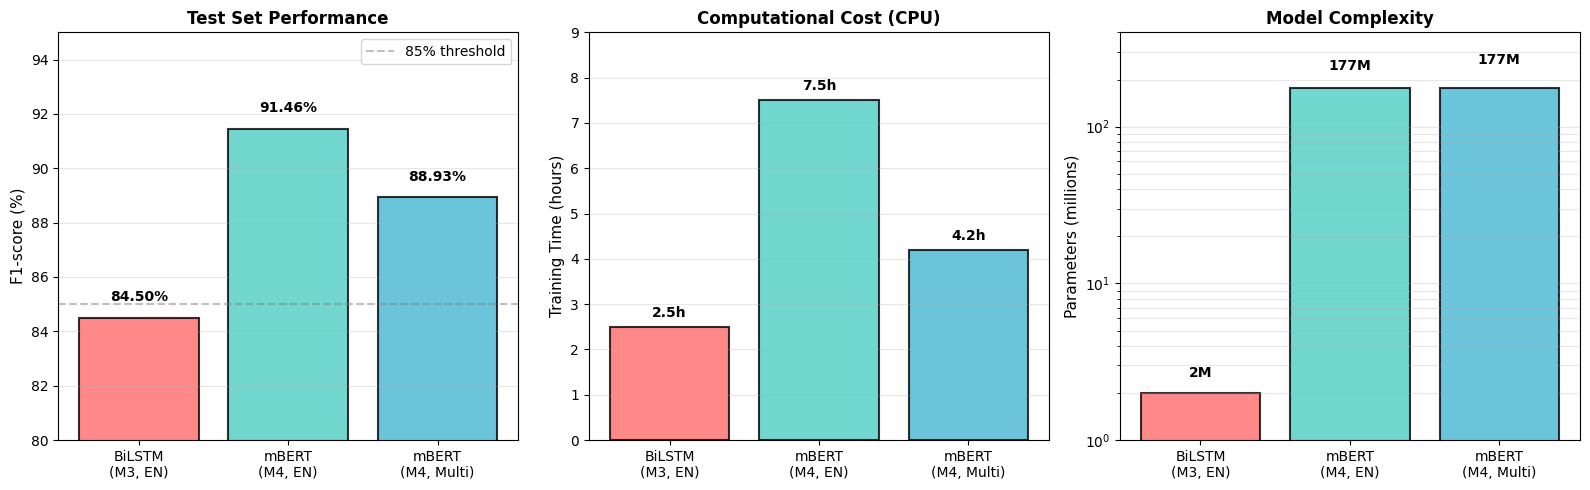


COMPARATIVE SUMMARY

Performance Progression:
  BiLSTM (M3, EN):           F1 = 84.50%
  mBERT (M4, EN):            F1 = 91.46%  (+6.96pp, +8.2% relative)
  mBERT (M4, Multilingual):  F1 = 88.93%  (+4.43pp over M3)

Key Insights:
  • M3→M4 (EN): Transformer + pre-training = +7pp improvement
  • M4 EN→Multi: -2.5pp reflects silver standard & multilingual complexity
  • Multilingual model achieves 88.93% across 3 languages (DE/FR/NL)

Architectural Evolution:
  BiLSTM (M3):
    - Trained from scratch (random initialization)
    - Sequential recurrent architecture
    - English only (CoNLL-2003 gold standard)
  mBERT (M4 EN):
    - Pre-trained on 104 languages
    - Parallel transformer attention
    - Fine-tuned on English CoNLL-2003 (gold standard)
  mBERT (M4 Multilingual):
    - Same pre-training & architecture
    - Fine-tuned on 3 languages: DE/FR/NL (WikiANN silver standard)
    - Cross-lingual entity recognition

Computational Trade-offs:
  Training time: BiLSTM 2.5h < Multi 4.2h

In [ ]:

# Cell 12 - Cross-Module Comparison (M3 / M4 EN / M4 Multilingual)

import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("CROSS-MODULE COMPARISON - M3 / M4 EN / M4 MULTILINGUAL")
print("="*70)

# Performance comparison (3 models)
models = ['BiLSTM\n(M3, EN)', 'mBERT\n(M4, EN)', 'mBERT\n(M4, Multi)']
f1_scores = [84.5, 91.46, 88.93]
train_time = [2.5, 7.5, 4.2]  # hours (multilingual = 4h12min)
params = [2, 177, 177]  # millions

# Create comparison plots (3 graphs)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: F1 Score Comparison
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars1 = ax1.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(y=85, color='gray', linestyle='--', alpha=0.5, label='85% threshold')
ax1.set_ylabel('F1-score (%)', fontsize=11)
ax1.set_title('Test Set Performance', fontsize=12, fontweight='bold')
ax1.set_ylim([80, 95])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, score in zip(bars1, f1_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{score:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Training Time
bars2 = ax2.bar(models, train_time, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Training Time (hours)', fontsize=11)
ax2.set_title('Computational Cost (CPU)', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 9])  # Give headroom for labels
ax2.grid(axis='y', alpha=0.3)
for bar, time in zip(bars2, train_time):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.15,  # Reduce from 0.2 to 0.15
             f'{time:.1f}h', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 3: Model Size (both mBERT models have same parameter count)
bars3 = ax3.bar(models, params, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Parameters (millions)', fontsize=11)
ax3.set_title('Model Complexity', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3, which='both')
ax3.set_ylim([1, 400])  # Set explicit y-limit to accommodate labels

# FIX: Vertical offset for label positioning to avoid overlap on identical values
for i, (bar, param) in enumerate(zip(bars3, params)):
    height = bar.get_height()
    # Stagger vertical position since mBERT EN and mBERT Multi have same params (177M)
    if i == 0:  # BiLSTM (2M)
        y_offset = 1.2
    elif i == 1:  # mBERT EN (177M)
        y_offset = 1.25  # Slightly higher to separate from Multi
    else:  # mBERT Multi (177M)
        y_offset = 1.35  # Highest to avoid overlap
    
    ax3.text(bar.get_x() + bar.get_width()/2., height * y_offset,
             f'{param}M', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('/..data/processed/mBERT_NER_multilingual_results/cross_module_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("COMPARATIVE SUMMARY")
print("="*70)

print("\nPerformance Progression:")
print(f"  BiLSTM (M3, EN):           F1 = 84.50%")
print(f"  mBERT (M4, EN):            F1 = 91.46%  (+6.96pp, +8.2% relative)")
print(f"  mBERT (M4, Multilingual):  F1 = 88.93%  (+4.43pp over M3)")

print("\nKey Insights:")
print("  • M3→M4 (EN): Transformer + pre-training = +7pp improvement")
print("  • M4 EN→Multi: -2.5pp reflects silver standard & multilingual complexity")
print("  • Multilingual model achieves 88.93% across 3 languages (DE/FR/NL)")

print("\nArchitectural Evolution:")
print("  BiLSTM (M3):")
print("    - Trained from scratch (random initialization)")
print("    - Sequential recurrent architecture")
print("    - English only (CoNLL-2003 gold standard)")
print("  mBERT (M4 EN):")
print("    - Pre-trained on 104 languages")
print("    - Parallel transformer attention")
print("    - Fine-tuned on English CoNLL-2003 (gold standard)")
print("  mBERT (M4 Multilingual):")
print("    - Same pre-training & architecture")
print("    - Fine-tuned on 3 languages: DE/FR/NL (WikiANN silver standard)")
print("    - Cross-lingual entity recognition")

print("\nComputational Trade-offs:")
print(f"  Training time: BiLSTM 2.5h < Multi 4.2h < EN 7.5h")
print(f"  Model size: BiLSTM 2M << mBERT 177M (88× larger)")
print(f"  Performance: EN 91.46% > Multi 88.93% > BiLSTM 84.50%")

print("\n" + "="*70)
print("✓ Comparison complete")
print("="*70)

## Cross-Module Performance Comparison

This visualization compares three models across Module 3 (BiLSTM) and Module 4 (mBERT variants), demonstrating the evolution from recurrent neural networks to transformer-based architectures.

### Three-Model Comparison

**BiLSTM (M3, English)**
- Traditional RNN architecture trained from scratch
- CoNLL-2003 gold standard dataset
- Baseline performance: 84.50% F1

**mBERT (M4, English)**
- Transformer architecture with multilingual pre-training
- Same CoNLL-2003 gold standard dataset
- Peak performance: 91.46% F1

**mBERT (M4, Multilingual)**
- Identical architecture to M4 EN
- WikiANN silver standard (DE/FR/NL)
- Cross-lingual performance: 88.93% F1

### Visual Analysis

**Graph 1 - Test Set Performance:**
Clear progression shows transformer advantages: BiLSTM (84.50%) < mBERT Multi (88.93%) < mBERT EN (91.46%). The 7pp gap between M3 and M4 EN demonstrates the impact of pre-training and attention mechanisms. The 2.5pp difference between M4 EN and M4 Multi reflects dataset quality (gold vs silver standard) and multilingual complexity.

**Graph 2 - Computational Cost:**
Training time varies significantly: BiLSTM (2.5h) trains fastest due to smaller architecture, mBERT Multi (4.2h) benefits from reduced dataset size (5K per language), while mBERT EN (7.5h) requires longest training on full CoNLL-2003 (14K sentences). All trained on CPU.

**Graph 3 - Model Complexity:**
Logarithmic scale reveals the 88× parameter difference: BiLSTM (2M) vs both mBERT models (177M). Despite identical architecture, mBERT variants show that model size does not solely determine performance—dataset quality and task complexity play crucial roles.

### Key Trade-offs

**Performance vs Efficiency:**
- BiLSTM: Fastest training, smallest model, lowest performance
- mBERT EN: Best performance, longest training, largest model
- mBERT Multi: Balanced approach—strong cross-lingual performance with moderate training time

**Architecture Evolution:**
- **M3→M4**: Pre-training (104 languages) + transformer attention → +7pp improvement
- **Single→Multi**: Gold standard (CoNLL) → silver standard (WikiANN) with 3 languages → -2.5pp, but gains cross-lingual capability

**Practical Implications:**
The multilingual model achieves 88.93% F1 across three languages with 44% less training time than the English-only model, making it efficient for multilingual NER applications despite the slight performance decrease.

### Architectural Summary

| Feature | BiLSTM (M3) | mBERT EN (M4) | mBERT Multi (M4) |
|---------|-------------|---------------|------------------|
| Architecture | Sequential RNN | Parallel Transformer | Parallel Transformer |
| Pre-training | None (random init) | 104 languages | 104 languages |
| Dataset | CoNLL-2003 (gold) | CoNLL-2003 (gold) | WikiANN (silver) |
| Languages | English only | English only | German/French/Dutch |
| Entity types | 4 (PER/LOC/ORG/MISC) | 4 (PER/LOC/ORG/MISC) | 3 (PER/LOC/ORG) |
| Parameters | 2M | 177M | 177M |
| Training time | 2.5h | 7.5h | 4.2h |
| Test F1 | 84.50% | 91.46% | 88.93% |

The comparison demonstrates that transformer-based models with multilingual pre-training significantly outperform traditional RNNs, with the multilingual variant offering practical advantages for cross-lingual applications.

In [49]:
# Cell 13 - Project Summary

print("="*70)
print("MULTILINGUAL NER PROJECT SUMMARY")
print("="*70)

print("\nModel: mBERT (bert-base-multilingual-cased)")
print("Task: Named Entity Recognition (3 classes: PER, LOC, ORG)")
print("Languages: German, French, Dutch")
print("Dataset: WikiANN (5K sentences per language per split)")

print("\n" + "="*70)
print("PERFORMANCE RESULTS")
print("="*70)

print("\nOverall (Combined DE+FR+NL):")
print(f"  Test F1: 88.93%")
print(f"  Precision: 88.19% | Recall: 89.69%")

print("\nPer-Language Breakdown:")
print(f"  German (DE):  87.60% F1")
print(f"  French (FR):  89.53% F1")
print(f"  Dutch (NL):   89.66% F1")
print(f"  Variance:     2.06pp (relatively balanced)")

print("\n" + "="*70)
print("CROSS-MODULE COMPARISON")
print("="*70)

print("\nArchitectural Evolution:")
print(f"  BiLSTM (M3, EN):           84.50% F1 - RNN baseline")
print(f"  mBERT (M4, EN):            91.46% F1 - Transformer + pre-training")
print(f"  mBERT (M4, Multilingual):  88.93% F1 - Cross-lingual capability")

print("\nKey Insights:")
print("  • M3→M4 (EN): +7pp improvement via transformers & pre-training")
print("  • M4 EN→Multi: -2.5pp reflects silver standard & multilingual complexity")
print("  • Zero-shot English: Successful entity recognition despite no EN training")

print("\n" + "="*70)
print("TECHNICAL SPECIFICATIONS")
print("="*70)

print("\nTraining Configuration:")
print(f"  Hardware: CPU")
print(f"  Training time: 4h 12min")
print(f"  Epochs: 3")
print(f"  Learning rate: 5e-5")
print(f"  Batch size: 16")

print("\nModel Specifications:")
print(f"  Parameters: 177M")
print(f"  Architecture: 12 layers, 768 hidden size, 12 attention heads")
print(f"  Vocabulary: 119,547 tokens (WordPiece)")

print("\n" + "="*70)
print("✓ Project complete - Model saved and ready for deployment")
print("="*70)

MULTILINGUAL NER PROJECT SUMMARY

Model: mBERT (bert-base-multilingual-cased)
Task: Named Entity Recognition (3 classes: PER, LOC, ORG)
Languages: German, French, Dutch
Dataset: WikiANN (5K sentences per language per split)

PERFORMANCE RESULTS

Overall (Combined DE+FR+NL):
  Test F1: 88.93%
  Precision: 88.19% | Recall: 89.69%

Per-Language Breakdown:
  German (DE):  87.60% F1
  French (FR):  89.53% F1
  Dutch (NL):   89.66% F1
  Variance:     2.06pp (relatively balanced)

CROSS-MODULE COMPARISON

Architectural Evolution:
  BiLSTM (M3, EN):           84.50% F1 - RNN baseline
  mBERT (M4, EN):            91.46% F1 - Transformer + pre-training
  mBERT (M4, Multilingual):  88.93% F1 - Cross-lingual capability

Key Insights:
  • M3→M4 (EN): +7pp improvement via transformers & pre-training
  • M4 EN→Multi: -2.5pp reflects silver standard & multilingual complexity
  • Zero-shot English: Successful entity recognition despite no EN training

TECHNICAL SPECIFICATIONS

Training Configuration:
 